# trajectory_analyze

particle trajectory analysis

file requirements:
- particle netcdf file generated by parcels after simulation
- the actual ocean data the particles ran on

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from datetime import timedelta, datetime
import math
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
import matplotlib.pyplot as plt

from utils import conv_to_dataarray, generate_mask, euc_dist, haversine
from parcels_utils import get_file_info, xr_dataset_to_fieldset
from plot_utils import plot_particles, get_carree_axis

In [3]:
# lOLOLOLOLOLOL
coastline_points = np.array([
    [32.527430, -117.123895],
    [32.534549, -117.123832],
    [32.549035, -117.125920],
    [32.556846, -117.130490],
    [32.560474, -117.131934],
    [32.562632, -117.132144],
    [32.564511, -117.132933],
    [32.575317, -117.132941],
    [32.576679, -117.133227],
    [32.593312, -117.133008],
    [32.616745, -117.136719],
    [32.640275, -117.146353],
    [32.662540, -117.160633],
    [32.679572, -117.180263],
    [32.687357, -117.198503],
    [32.683428, -117.223487]
])

tijuana_mouth = np.array([32.551967, -117.127208])

In [4]:
# ocean current netcdf data the particles used
d_nc = "current_netcdfs/west_coast_1km_hourly/tijuana_river_lin.nc"
# the data generated by ParticleFile
p_nc = "particledata/particle_tijuana_lin.nc"

In [5]:
d_info = get_file_info(d_nc, 1)
d_ds = xr.open_dataset(d_nc)
p_ds = xr.open_dataset(p_nc)
fs = xr_dataset_to_fieldset(d_ds)
d_ds.close()
p_ds.close()

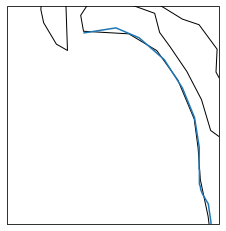

In [6]:
ax = get_carree_axis(d_info["domain"])
# plt.scatter(coastline_points.T[1], coastline_points.T[0])
plt.plot(coastline_points.T[1], coastline_points.T[0])

so this doesn't actually find the closest distance to the coastline, but the closest distance to one of the points defined to be the coastline because it's easier

dists = np.empty((p_ds.dims["traj"], p_ds.dims["obs"]))
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        if np.isnan(p_ds["trajectory"].isel(traj=i, obs=j)):
            dists[i, j:] = np.nan
            break
        lat = p_ds["lat"].isel(traj=i, obs=j)
        lon = p_ds["lon"].isel(traj=i, obs=j)
        p = np.array([lat, lon])
#         point_dists = [euc_dist(p, coast_p) for coast_p in coastline_points]
#         closest = coastline_points[np.where(point_dists == min(point_dists))]
        closest = np.array([tijuana_mouth])
        dists[i, j] = haversine(lat, closest[0, 0], lon, closest[0, 1])  # meters

dists

In [7]:
d_mask = conv_to_dataarray(generate_mask(d_ds["u"].values), d_ds["u"])

### check whether a particle collided with land

conditions:
- only check the latest position of a particle before it's deleted or stuck on land or something
- particle is on a position where even after fieldset interpolation, vector values are still zero

however, there may be some regions of actual ocean that just don't have data, so it's not foolproof

### edit

got a long ass list of coordinates representing the coastline now, and all the points will essentially be on the "bottom-left" of the coastline, so easy check i guess

In [8]:
def collided_with_coastline(lat, lon):
    upmost = coastline_points.T[0].max()
    rightmost = coastline_points.T[1].max()
    return lat > upmost or lon > rightmost


def time_to_str(time):
    """
    haha time go chop chop
    
    Args:
        time (np.datetime64)
    """
    return str(time).split(".")[0]

### some immediate problems

- particles are out of bounds even though I use coordinate values on the SAME FIELDSET during simulation
    - ??????????????? how


In [9]:
collided_land = np.zeros(p_ds["trajectory"].shape, dtype=bool)
lat_ls_coll = []
lon_ls_coll = []
times_sec = []
times_dates = []
part_dists = []
for p_iter in range(len(p_ds["trajectory"])):
    p = p_ds["trajectory"][p_iter]
    # find the first state of the particle where it got stuck on land something
    for step in range(len(p)):
        if np.isnan(p[step]):
            break
        time = p_ds["time"].values[p_iter, step]
        time_secs = p_ds["lifetime"].values[p_iter, step] + p_ds["spawntime"].values[p_iter, step]
        lat = p_ds["lat"].values[p_iter, step]
        lon = p_ds["lon"].values[p_iter, step]
        times_sec.append(time_secs)
        times_dates.append(time)
#         part_dists.append(dists[p_iter, step])
        # first, check if the vector speed at that coordinate is 0 after interpolation
        # second, check if the particle is not in an invalid coordinate (a coordinate supposed to have data)
        total_vel = abs(fs.U[time_secs, 0, lat, lon]) + abs(fs.V[time_secs, 0, lat, lon])
        if collided_with_coastline(lat, lon):
#         if total_vel <= sys.float_info.epsilon and not d_mask.sel(time=time, lat=lat, lon=lon, method="nearest"):
            lat_ls_coll.append(lat)
            lon_ls_coll.append(lon)
            print(f"particle {p_iter} beached at time {time_to_str(time)}")
            print(f"    spawn time: {time_to_str(p_ds['time'].values[p_iter, 0])}")
            print(f"    spawn coord: ({p_ds['lat'].values[p_iter, 0]}, {p_ds['lon'].values[p_iter, 0]})")
            print(f"    lifetime: {p_ds['lifetime'].values[p_iter, step]}")
            break

particle 0 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.556941986083984, -117.13707733154297)
    lifetime: 0.0
particle 1 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.55678939819336, -117.13687133789062)
    lifetime: 0.0
particle 2 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.551509857177734, -117.13865661621094)
    lifetime: 0.0
particle 3 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.55836868286133, -117.13704681396484)
    lifetime: 0.0
particle 4 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.55656814575195, -117.13898468017578)
    lifetime: 0.0
particle 5 beached at time 2020-06-16T21:00:00
    spawn time: 2020-06-16T21:00:00
    spawn coord: (32.55693817138672, -117.13667297363281)
    lifetime: 0.0
particle 6 beached at time 2020-06-16T21:00:

particle 91 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55156326293945, -117.13721466064453)
    lifetime: 0.0
particle 92 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55021667480469, -117.13671875)
    lifetime: 0.0
particle 93 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55223083496094, -117.13886260986328)
    lifetime: 0.0
particle 94 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55195617675781, -117.13716888427734)
    lifetime: 0.0
particle 95 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55848693847656, -117.13777923583984)
    lifetime: 0.0
particle 96 beached at time 2020-06-18T09:00:00
    spawn time: 2020-06-18T09:00:00
    spawn coord: (32.55032730102539, -117.1385726928711)
    lifetime: 0.0
particle 97 beached at time 2020-06-18T09:00:00

particle 190 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.55374526977539, -117.13408660888672)
    lifetime: 7200.0
particle 191 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.54820251464844, -117.13355255126953)
    lifetime: 7200.0
particle 192 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.549434661865234, -117.13506317138672)
    lifetime: 7200.0
particle 193 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.55381393432617, -117.13459777832031)
    lifetime: 7200.0
particle 194 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.5484619140625, -117.13502502441406)
    lifetime: 7200.0
particle 195 beached at time 2020-06-20T03:00:00
    spawn time: 2020-06-20T03:00:00
    spawn coord: (32.553951263427734, -117.13494110107422)
    lifetime: 7200.0
particle 196 be

particle 285 beached at time 2020-06-21T15:00:00
    spawn time: 2020-06-21T15:00:00
    spawn coord: (32.548580169677734, -117.13190460205078)
    lifetime: 7200.0
particle 286 beached at time 2020-06-21T15:00:00
    spawn time: 2020-06-21T15:00:00
    spawn coord: (32.54820251464844, -117.13188171386719)
    lifetime: 7200.0
particle 287 beached at time 2020-06-21T15:00:00
    spawn time: 2020-06-21T15:00:00
    spawn coord: (32.54866027832031, -117.1322021484375)
    lifetime: 7200.0
particle 288 beached at time 2020-06-21T15:00:00
    spawn time: 2020-06-21T15:00:00
    spawn coord: (32.55402374267578, -117.13337707519531)
    lifetime: 7200.0
particle 289 beached at time 2020-06-21T15:00:00
    spawn time: 2020-06-21T15:00:00
    spawn coord: (32.55293273925781, -117.13379669189453)
    lifetime: 7200.0
particle 290 beached at time 2020-06-21T18:00:00
    spawn time: 2020-06-21T18:00:00
    spawn coord: (32.553855895996094, -117.13710021972656)
    lifetime: 3600.0
particle 291 be

    spawn coord: (32.55211639404297, -117.13664245605469)
    lifetime: 0.0
particle 338 beached at time 2020-06-22T09:00:00
    spawn time: 2020-06-22T09:00:00
    spawn coord: (32.55622100830078, -117.13919830322266)
    lifetime: 0.0
particle 339 beached at time 2020-06-22T09:00:00
    spawn time: 2020-06-22T09:00:00
    spawn coord: (32.55585861206055, -117.13790130615234)
    lifetime: 0.0
particle 340 beached at time 2020-06-22T15:00:00
    spawn time: 2020-06-22T15:00:00
    spawn coord: (32.55046463012695, -117.14076232910156)
    lifetime: 7200.0
particle 341 beached at time 2020-06-22T15:00:00
    spawn time: 2020-06-22T15:00:00
    spawn coord: (32.556087493896484, -117.13935089111328)
    lifetime: 7200.0
particle 342 beached at time 2020-06-22T15:00:00
    spawn time: 2020-06-22T15:00:00
    spawn coord: (32.55826187133789, -117.13841247558594)
    lifetime: 7200.0
particle 343 beached at time 2020-06-22T15:00:00
    spawn time: 2020-06-22T15:00:00
    spawn coord: (32.550

30, 31, 32, 33, 34, 37, 38, 39

plt.hist2d(times_sec, part_dists)
plt.show()

In [10]:
lats_all = []
lons_all = []
age_all = []
final_time = d_ds["time"].max().values
for p_iter in range(len(p_ds["trajectory"])):
    p = p_ds["trajectory"][p_iter]
    for step in reversed(range(len(p))):
        if not np.isnan(p[step]) and p_ds["time"].values[p_iter, step] == final_time:
            lats_all.append(p_ds["lat"].values[p_iter, step])
            lons_all.append(p_ds["lon"].values[p_iter, step])
            age_all.append(p_ds["lifetime"].values[p_iter, step])
            break

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


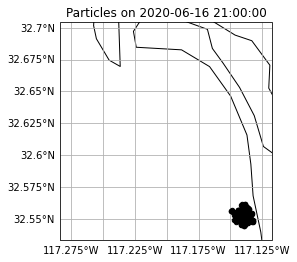

In [11]:
plot_particles(fs, lat_ls_coll, lon_ls_coll)

In [12]:
d_info["domain"]

{'S': 32.53346, 'N': 32.70427, 'W': -117.28391, 'E': -117.11733}

In [13]:
def show_particles_age(lats, lons, ages, domain):
    ext = [domain["W"], domain["E"], domain["S"], domain["N"]]
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(ext)
    ax.add_feature(cartopy.feature.COASTLINE)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels, gl.right_labels = (False, False)
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.scatter(lons, lats, c=ages, edgecolors='k', vmin=0)
    plt.colorbar()
    plt.title(f"Particle ages")
    plt.show()

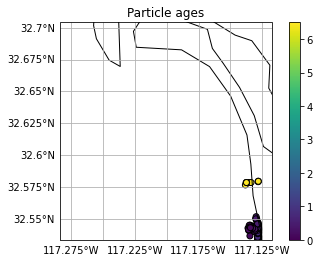

In [14]:
seconds_to_days = 1 / 86400
age_days = np.array(age_all) * seconds_to_days
# print(age_days)
d = d_info["domain"]

show_particles_age(lats_all, lons_all, age_days, d)